# Calibration Model 01: Bayesovská kalibrace (Bayes Calibration)

### Počet kalibrovaných parametrů: 3

### Kalibrační framework

* Zarovnat časové osy

* Definovat dynamický model

* Zavést prior na parametry

* Zavést prior na šum

* Přidat modelovou diskrepanci

* MCMC sampling

* Posterior predictive kontrola

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib
#%pip install pymc
#%pip install arviz
#%pip install ipywidgets
#%pip install jupyterlab_widgets
#%pip install pytensor
#%pip install ipywidgets jupyterlab_widgets

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az
import pytensor.tensor as pt

import seaborn as sns
import matplotlib.pyplot as plt

### Vstupní data

In [3]:
### Načtení časosběru

# Soubor je načten a přiřazen do proměnné ‚df‘
other_path = '../../data/02_DetermModel/model_data_real.csv'
df = pd.read_csv(other_path, header=0)
df = df[['id', 'x', 'y', 'z', 'dist', 'time', 'total_time']]
df

,id,x,y,z,dist,time,total_time
0,150,1315,220,1000,3443,29,29
1,75,220,1190,500,3590,33,33
2,239,220,940,2000,4387,35,41
3,199,1315,220,1500,3636,36,36
4,51,3690,220,250,5767,50,50
...,...,...,...,...,...,...,...
156,83,220,3190,500,1970,29,29
157,26,1815,220,0,3943,45,45
158,190,220,690,1500,4351,33,33
159,234,220,3815,1750,2990,27,27


### Vhodné parametry pro kalibraci

| Parametr         | Kalibrovat      | Důvod                          |
| ---------------- | --------------- | ------------------------------ |
| speed_max_load   | Ano               | reálná rychlost ≠ nominální    |
| speed_max_unload | Ano               | často vyšší variabilita        |
| accel            | Ano               | výrazně ovlivňuje krátké cykly |
| pevné časy       | Ne (slabý prior)  | většinou měřené přesně         |

In [4]:
dist = df["dist"].values
time_real = df["time"].values

### Fyzikální model (vektorový)

In [5]:
def move_time(dist, v, a):

    t_acc = v / a
    d_acc = 0.5 * a * t_acc**2
    d_crit = 2 * d_acc

    # trojúhelníkový profil
    triangular = 2 * pt.sqrt(dist / a)

    # trapezoidální profil
    trapezoidal = 2 * t_acc + (dist - d_crit) / v

    return pt.switch(dist < d_crit,
                     triangular,
                     trapezoidal)

### Kompletní model

In [6]:
with pm.Model() as model:

    # ------------------------
    # Priory (fyzikálně omezené)
    # ------------------------

    v_load = pm.TruncatedNormal("v_load",
                                 mu=0.5,
                                 sigma=0.2,
                                 lower=0.1)

    v_unload = pm.TruncatedNormal("v_unload",
                                   mu=1.0,
                                   sigma=0.3,
                                   lower=0.2)

    accel = pm.TruncatedNormal("accel",
                                mu=1.0,
                                sigma=0.3,
                                lower=0.2)

    sigma = pm.HalfNormal("sigma", 0.2)

    # ------------------------
    # Fixní část cyklu
    # ------------------------

    time_refer_2_refer = 20   # s, průměrná doba pohybu z referenčního bodu k referenčnímu bodu (depaletizace, verifikace)
    time_mounting = 3         # s, doba manipulaci v cílové poloze (umístění prvku)

    T_fix = time_refer_2_refer + time_mounting
    # ------------------------
    # Pohyb
    # ------------------------

    T_load = move_time(dist/1000, v_load, accel)
    T_unload = move_time(dist/1000, v_unload, accel)

    mu = T_fix + T_load + T_unload

    # ------------------------
    # Likelihood
    # ------------------------

    y = pm.Normal("y",
                  mu=mu,
                  sigma=sigma,
                  observed=time_real)

    trace = pm.sample(3000,
                      tune=2000,
                      target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_load, v_unload, accel, sigma]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 11 seconds.


### Diagnostika

array([[<Axes: title={'center': 'v_load'}>,
        <Axes: title={'center': 'v_load'}>],
       [<Axes: title={'center': 'v_unload'}>,
        <Axes: title={'center': 'v_unload'}>],
       [<Axes: title={'center': 'accel'}>,
        <Axes: title={'center': 'accel'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

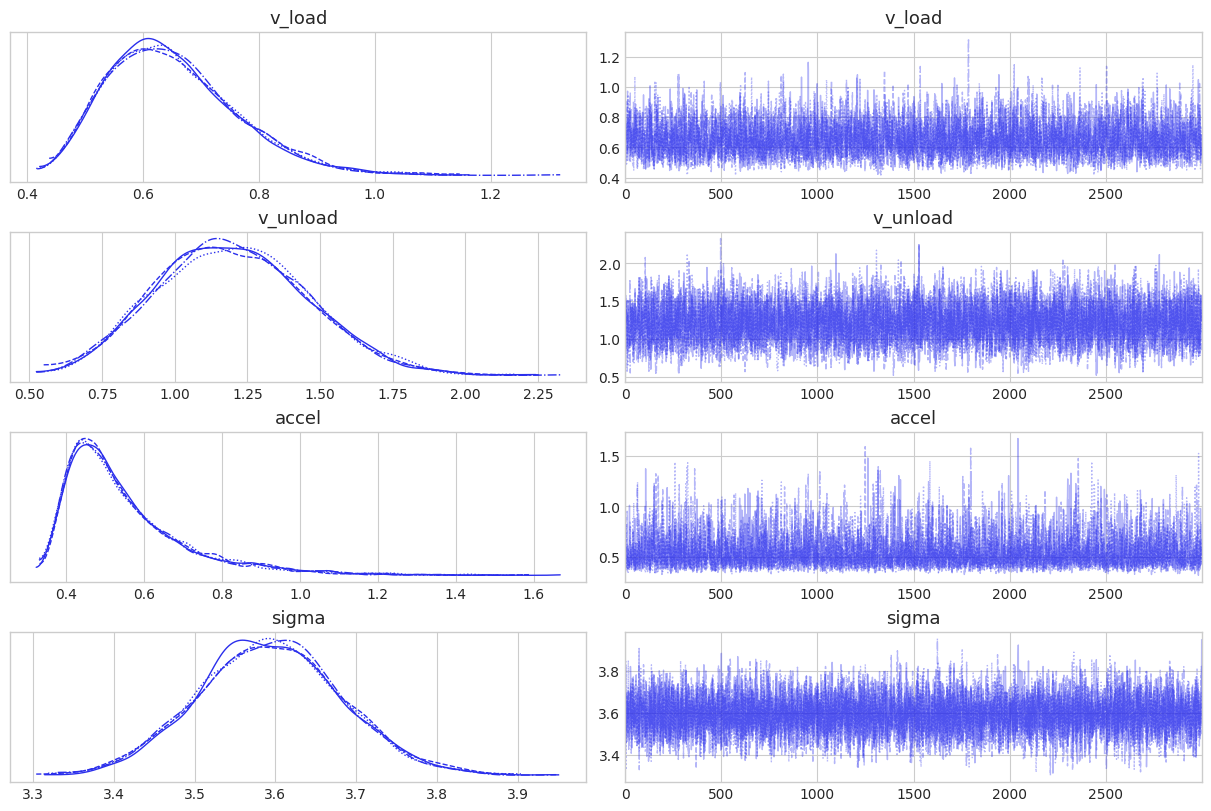

In [7]:
az.summary(trace)

az.style.use("arviz-whitegrid")

plt.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.0,
})

az.plot_trace(trace)

### Posterior predictive kontrola

In [8]:
with model:
    trace.extend(
        pm.sample_posterior_predictive(trace)
    )

Sampling: [y]


Output()

C:\Users\usman\AppData\Local\Temp\ipykernel_26088\3615469113.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


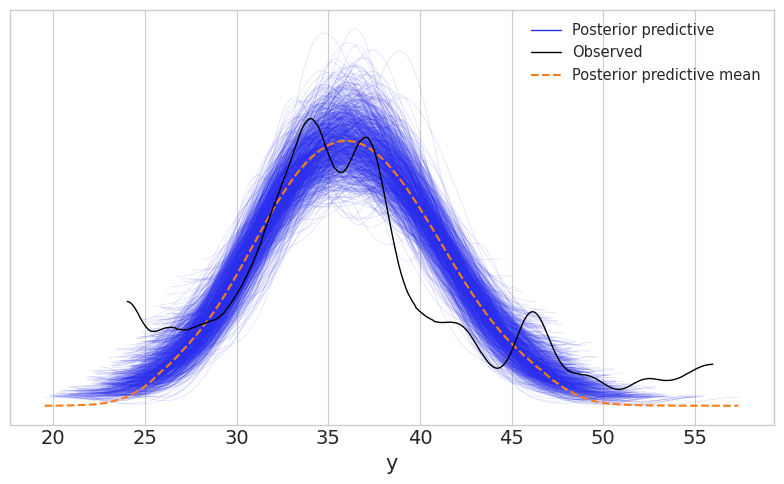

In [9]:
az.style.use("arviz-whitegrid")

fig, ax = plt.subplots(figsize=(8,5))

az.plot_ppc(
    trace,
    num_pp_samples=1000,     # don't plot all draws!
    kind="kde",
    mean=True,
    observed=True,
    alpha=0.15,
    ax=ax
)

plt.tight_layout()

### Souhrnná statistika posteriorní prediktivní distribuce modelu

In [10]:
summary_df = az.summary(trace, group="posterior_predictive")
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y[0],35.076,3.648,27.950,41.694,0.034,0.024,11780.0,11754.0,1.0
y[1],35.395,3.623,28.546,42.153,0.033,0.023,11754.0,11610.0,1.0
y[2],37.378,3.629,30.475,44.050,0.033,0.024,11829.0,11373.0,1.0
y[3],35.472,3.642,28.580,42.283,0.033,0.024,11944.0,11685.0,1.0
y[4],40.741,3.655,34.193,47.982,0.033,0.024,12393.0,11902.0,1.0
...,...,...,...,...,...,...,...,...,...
y[156],31.350,3.587,24.531,38.050,0.033,0.023,11538.0,11687.0,1.0
y[157],36.211,3.589,29.611,43.083,0.033,0.023,11917.0,11931.0,1.0
y[158],37.231,3.594,30.660,44.089,0.033,0.023,11562.0,11187.0,1.0
y[159],33.884,3.649,27.332,40.911,0.033,0.024,12204.0,11572.0,1.0


### Export datové sady do formátu netCDF a CSV

https://www.unidata.ucar.edu/software/netcdf

In [11]:
summary_df.to_csv("../../data/05_Calibration/posterior_predictive_summary_three.csv", index=False)

In [12]:
az.to_netcdf(trace, "../../data/05_Calibration/posterior_trace_three.nc")

'../../data/05_Calibration/posterior_trace_three.nc'

In [13]:
df_posterior = az.extract(trace, group="posterior").to_dataframe()
df_posterior.to_csv("../../data/05_Calibration/posterior_three.csv", index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-31 | 1.1 | Vjačeslav Usmanov| added CM_01_BayesCalibration.ipynb |
| 2026-02-18 | 1.2 | Vjačeslav Usmanov| changed CM_01_BayesCalibration.ipynb |